In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

#for save & load pickle
import sys
import os
import pickle

def save_as_pickled_object(obj, filepath):
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj, protocol=pickle.HIGHEST_PROTOCOL)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])


def try_to_load_as_pickled_object_or_None(filepath):
    max_bytes = 2**31 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


import os
PATH = "../csv/"
print(os.listdir(PATH))

['application_test.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
train = try_to_load_as_pickled_object_or_None('/Volumes/sub/kaggle/pkl/Home Credit Default Risk/train_data.pkl')
test = try_to_load_as_pickled_object_or_None('/Volumes/sub/kaggle/pkl/Home Credit Default Risk/test_data.pkl')

In [4]:
def train_test_crate_val(df):
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    # add features
    df['NEW_INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    df['NEW_REGISTRATION_TO_BIRTH_RATIO'] = df['DAYS_REGISTRATION'] / df['DAYS_BIRTH']
    df['NEW_PUBLISH_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['NEW_CREDIT_TO_BIRTH_RATIO'] = df['AMT_CREDIT'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_BIRTH_RATIO'] = df['AMT_ANNUITY'] / df['DAYS_BIRTH']
    df['NEW_INCOME_TO_EMPLOY_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['NEW_REGISTRATION_TO_EMPLOY_RATIO'] = df['DAYS_REGISTRATION'] / df['DAYS_EMPLOYED']
    df['NEW_PUBLISH_TO_EMPLOY_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_EMPLOY_RATIO'] = df['AMT_CREDIT'] / df['DAYS_EMPLOYED']
    df['NEW_ANNUITY_TO_EMPLOY_RATIO'] = df['AMT_ANNUITY'] / df['DAYS_EMPLOYED']
    df['NEW_EXT_SOURCES_1_TO_MEAN_RATIO'] = df['EXT_SOURCE_1'] / df['NEW_EXT_SOURCES_MEAN']
    df['NEW_EXT_SOURCES_2_TO_MEAN_RATIO'] = df['EXT_SOURCE_2'] / df['NEW_EXT_SOURCES_MEAN']
    df['NEW_EXT_SOURCES_3_TO_MEAN_RATIO'] = df['EXT_SOURCE_3'] / df['NEW_EXT_SOURCES_MEAN']
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_PRICE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_ANNUITY_TO_GOODS_PRICE_RATIO'] = df['AMT_ANNUITY'] / df['AMT_GOODS_PRICE']
    df['NEW_INCOME_TO_GOODS_PRICE_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_GOODS_PRICE']
    df['NEW_REGISTRATION_TO_PUBLISH_RATIO'] = df['DAYS_REGISTRATION'] / df['DAYS_ID_PUBLISH']
    df['NEW_INCOME_TO_PHONE_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_LAST_PHONE_CHANGE']
    df['NEW_CREDIT_TO_PHONE_RATIO'] = df['AMT_CREDIT'] / df['DAYS_LAST_PHONE_CHANGE']
    df['NEW_ANNUITY_TO_PHONE_RATIO'] = df['AMT_ANNUITY'] / df['DAYS_LAST_PHONE_CHANGE']
    df['NEW_GOODS_PRICE_TO_PHONE_RATIO'] = df['AMT_GOODS_PRICE'] / df['DAYS_LAST_PHONE_CHANGE']
    return df

train = train_test_crate_val(train)
test = train_test_crate_val(test)

/Users/hotaruco/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)
/Users/hotaruco/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [5]:
#from imblearn.under_sampling import RandomUnderSampler
#rus = RandomUnderSampler(random_state=314)
#X_rus, y_rus = rus.fit_sample(application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(-1), 
#                              application_train_ohe['TARGET'])

# You can use the full sample and do sample weighting in lightgbm using `is_unbalance` OR `scale_pos_weight` argument
# But it makes the code to run 8x..10x slower, which is ok for the run with pre-optimised parametersm but is too slow for HP optimisation
X_rus, y_rus = (train.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                train['TARGET'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=314, stratify=y_rus)

In [7]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [8]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [9]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
#clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=1000)
# LightGBM parameters found by Bayesian optimization
clf = lgb.LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    subsample_freq=1,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=60 , # 39.3259775,
    random_state=314,
    silent=-1,
    verbose=-1, )

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [10]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

In [11]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9234, learning_rate=0.02, max_depth=8,
        min_child_samples=399, min_child_weight=0.1,
        min_split_gain=0.0222415, n_estimators=10000, n_jobs=-1, nthread=4,
        num_leaves=13, objective=None, random_state=314, reg_alpha=2,
        reg_lambda=5, silent=-1, subsample=0.855, subsample_for_bin=200000,
        subsample_freq=1, verbose=-1)

In [12]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=3,
                                refit=True,
                                verbose=True)

In [13]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.737744
[200]	valid's auc: 0.756634
[300]	valid's auc: 0.769621
[400]	valid's auc: 0.776381
[500]	valid's auc: 0.780709
[600]	valid's auc: 0.783282
[700]	valid's auc: 0.784991
[800]	valid's auc: 0.786144
[900]	valid's auc: 0.787121
[1000]	valid's auc: 0.787778
[1100]	valid's auc: 0.788421
[1200]	valid's auc: 0.788872
[1300]	valid's auc: 0.789249
[1400]	valid's auc: 0.789531
Early stopping, best iteration is:
[1390]	valid's auc: 0.789562
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.738922
[200]	valid's auc: 0.755644
[300]	valid's auc: 0.7682
[400]	valid's auc: 0.775032
[500]	valid's auc: 0.779103
[600]	valid's auc: 0.78186
[700]	valid's auc: 0.783461
[800]	valid's auc: 0.784357
[900]	valid's auc: 0.785399
[1000]	valid's auc: 0.786088
[1100]	valid's auc: 0.786788
[1200]	valid's auc: 0.787307
[1300]	valid's auc:

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 151.5min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.745331
[200]	valid's auc: 0.761974
[300]	valid's auc: 0.772371
[400]	valid's auc: 0.778352
[500]	valid's auc: 0.782114
[600]	valid's auc: 0.784823
[700]	valid's auc: 0.786685
[800]	valid's auc: 0.787888
[900]	valid's auc: 0.788746
[1000]	valid's auc: 0.789457
[1100]	valid's auc: 0.79003
[1200]	valid's auc: 0.790607
[1300]	valid's auc: 0.791205
[1400]	valid's auc: 0.791702
[1500]	valid's auc: 0.792035
[1600]	valid's auc: 0.792347
[1700]	valid's auc: 0.792612
[1800]	valid's auc: 0.792808
[1900]	valid's auc: 0.792981
[2000]	valid's auc: 0.793239
[2100]	valid's auc: 0.793379
[2200]	valid's auc: 0.793541
Early stopping, best iteration is:
[2265]	valid's auc: 0.793675
Best score reached: 0.7854187504010718 with params: {'scale_pos_weight': 2} 


In [14]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))

Valid+-Std     Train  :   Parameters
0.784+-0.002     0.838   :  {'scale_pos_weight': 6}
0.784+-0.001     0.850   :  {'scale_pos_weight': 12}
0.785+-0.001     0.840   :  {'scale_pos_weight': 1}
0.785+-0.002     0.851   :  {'scale_pos_weight': 2}


/Users/hotaruco/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [15]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [16]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#force larger number of max trees and smaller learning rate
clf_final.set_params(n_estimators=50000, learning_rate=0.005, objective='binary')
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.775456
[200]	valid's auc: 0.783913
[300]	valid's auc: 0.786315
[400]	valid's auc: 0.78724
[500]	valid's auc: 0.787789
[600]	valid's auc: 0.788068
[700]	valid's auc: 0.788232
[800]	valid's auc: 0.788328
[900]	valid's auc: 0.788371
[1000]	valid's auc: 0.788409
[1100]	valid's auc: 0.78845
[1200]	valid's auc: 0.788487
[1300]	valid's auc: 0.788524
[1400]	valid's auc: 0.788567
[1500]	valid's auc: 0.788604
[1600]	valid's auc: 0.78864
[1700]	valid's auc: 0.788671
[1800]	valid's auc: 0.788702
[1900]	valid's auc: 0.788742
[2000]	valid's auc: 0.788782
[2100]	valid's auc: 0.788814
[2200]	valid's auc: 0.788859
[2300]	valid's auc: 0.788889
[2400]	valid's auc: 0.788924
[2500]	valid's auc: 0.788956
[2600]	valid's auc: 0.788986
[2700]	valid's auc: 0.789013
[2800]	valid's auc: 0.789044
[2900]	valid's auc: 0.789077
[3000]	valid's auc: 0.789109
[3100]	valid's auc: 0.789144
[3200]	valid's auc: 0.789173
[3300]	valid's auc: 0.

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9234, learning_rate=0.005, max_depth=8,
        min_child_samples=399, min_child_weight=0.1,
        min_split_gain=0.0222415, n_estimators=50000, n_jobs=-1, nthread=4,
        num_leaves=13, objective='binary', random_state=314, reg_alpha=2,
        reg_lambda=5, silent=-1, subsample=0.855, subsample_for_bin=200000,
        subsample_freq=1, verbose=-1)

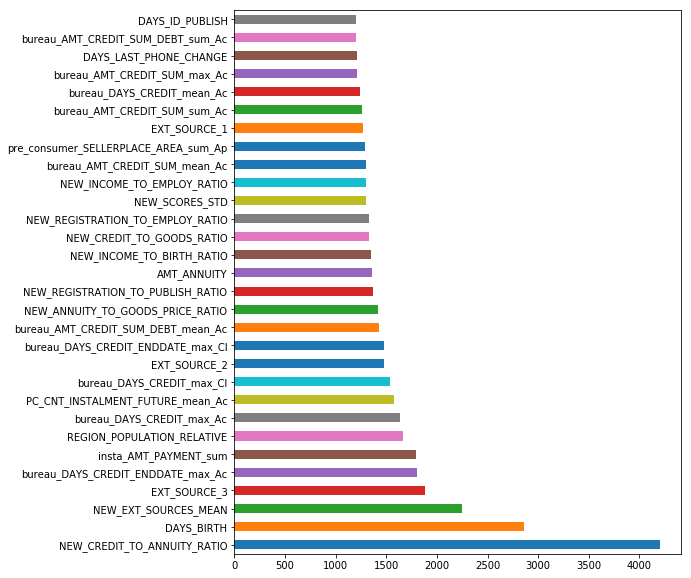

In [17]:
feat_imp = pd.Series(clf_final.feature_importances_, index=train.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [18]:
probabilities = clf_final.predict_proba(test.drop(['SK_ID_CURR'], axis=1))
submission = pd.DataFrame({
    'SK_ID_CURR': test['SK_ID_CURR'],
    'TARGET':     [ row[1] for row in probabilities]
})
submission.to_csv("submission11.csv", index=False)